In [1]:
import pandas as pd
import glob
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.statistics.traces.generic.log import case_statistics 
from pm4py.statistics import traces as trace_stats
from pm4py.statistics import attributes as attr_stats
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.statistics.traces.generic.log.case_arrival import get_case_arrival_avg
from pm4py.statistics.traces.generic.log.case_arrival import get_case_dispersion_avg
from pm4py.statistics.traces.generic.pandas import case_statistics as cs


In [3]:
trd_path = "data/trd_event_log.xes"
nontrd_path = "data/nontrd_event_log.xes"

trd_event_log = xes_importer.apply(trd_path)
nontrd_event_log = xes_importer.apply(nontrd_path)

parsing log, completed traces ::   0%|          | 0/4630 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/27251 [00:00<?, ?it/s]

In [4]:
def add_start_end_to_eventlog(log):
    new_log = EventLog()
    for trace in log:
        new_trace = Trace()
        start_event = dict(trace[0]).copy()
        start_event['concept:name'] = 'Start'
        start_event['time:timestamp'] = trace[0]['time:timestamp']
        new_trace.append(start_event)
        for ev in trace:
            ev_copy = dict(ev).copy()
            ev_copy['concept:name'] = str(ev_copy['concept:name'])  # <-- Force all labels to string
            new_trace.append(ev_copy)
        end_event = dict(trace[-1]).copy()
        end_event['concept:name'] = 'End'
        end_event['time:timestamp'] = trace[-1]['time:timestamp']
        new_trace.append(end_event)
        new_trace.attributes.update(trace.attributes)
        new_log.append(new_trace)
    new_log.attributes.update(log.attributes)
    return new_log


trdlog_with_start_end = add_start_end_to_eventlog(trd_event_log)
nontrdlog_with_start_end = add_start_end_to_eventlog(nontrd_event_log)

In [5]:
parameters = {"activity_key": "concept:name"}
dfg_trd = dfg_discovery.apply(trdlog_with_start_end, parameters=parameters)
dfg_nontrd = dfg_discovery.apply(nontrdlog_with_start_end, parameters=parameters)

In [6]:
threshold = 50

filtered_dfg_trd  = {
    edge: count
    for edge, count in dfg_trd.items()
    if (
        count >= threshold
        or edge[0] == "Start"
        or edge[1] == "End"
    )
}
filtered_dfg_nontrd  = {
    edge: count
    for edge, count in dfg_nontrd.items()
    if (
        count >= threshold
        or edge[0] == "Start"
        or edge[1] == "End"
    )
}

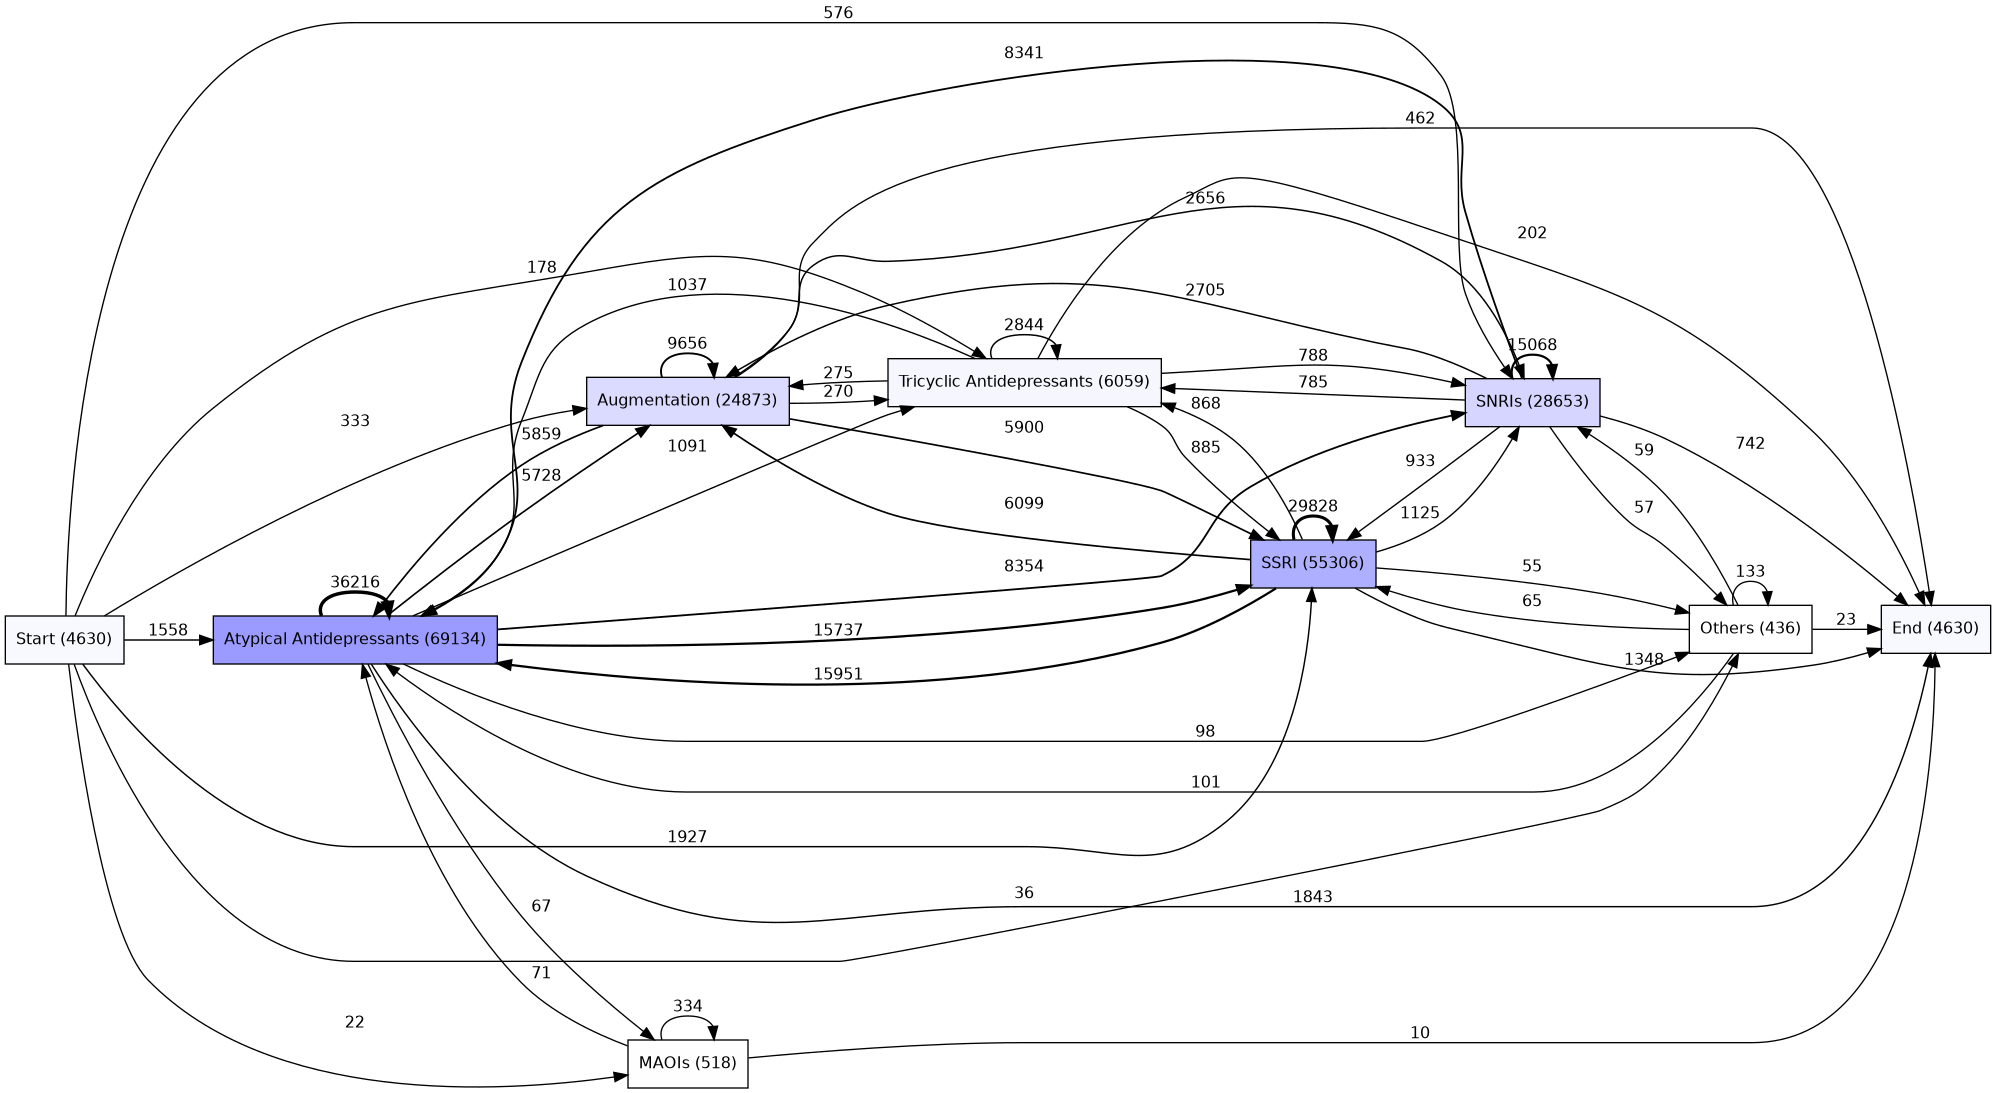

In [7]:
gviz_trd = dfg_visualizer.apply(
    filtered_dfg_trd, 
    log=trdlog_with_start_end, 
    variant=dfg_visualizer.Variants.FREQUENCY
)
dfg_visualizer.view(gviz_trd)

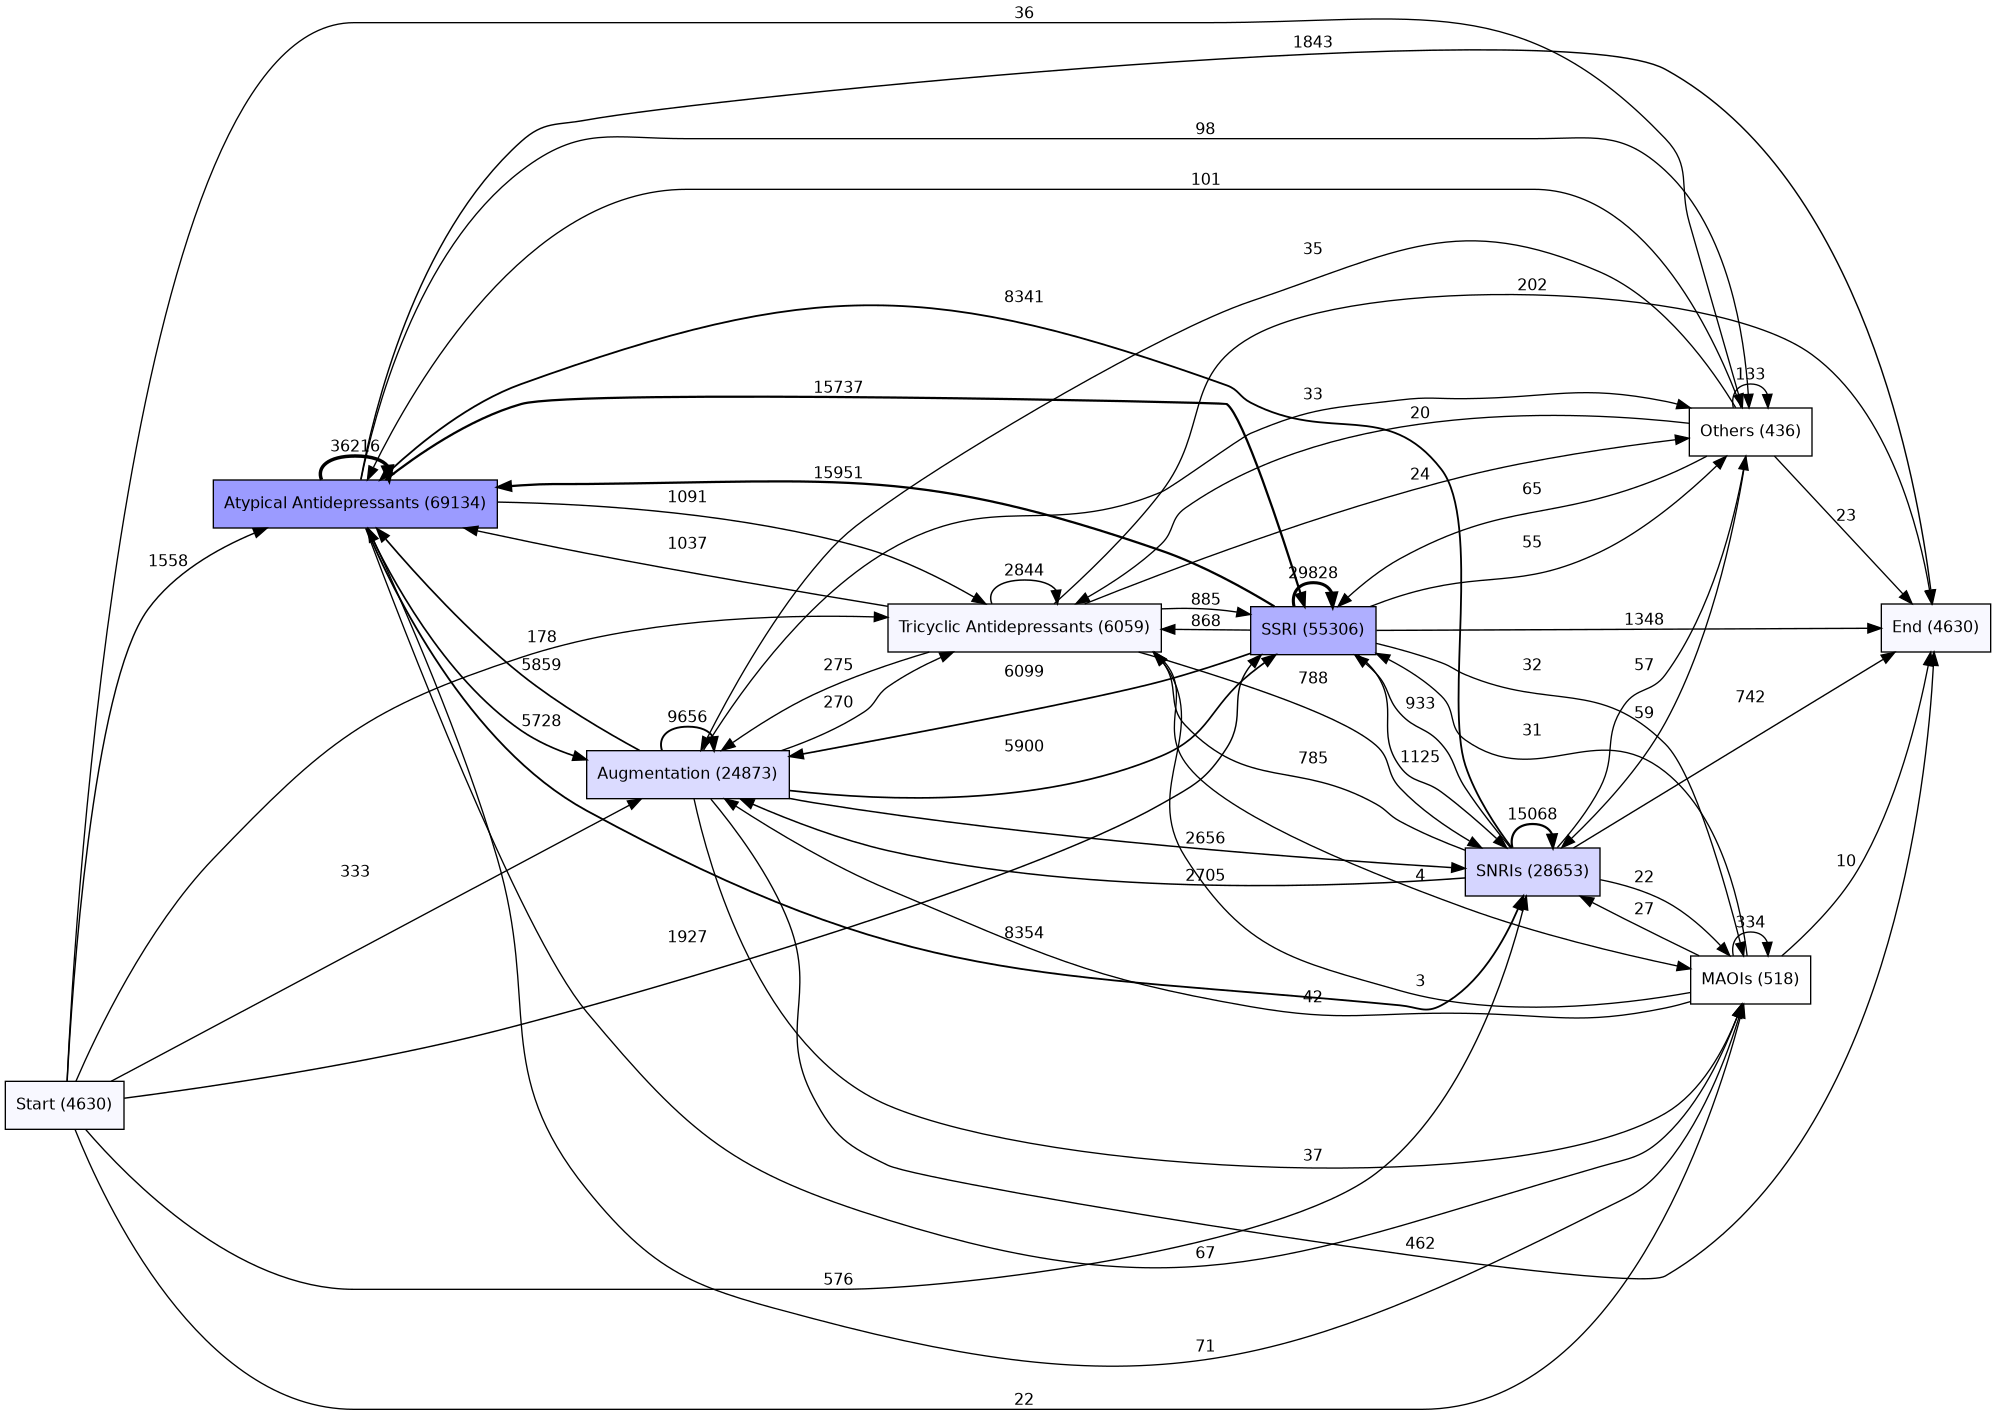

In [10]:
gviz_trd = dfg_visualizer.apply(
    dfg_trd, 
    log=trdlog_with_start_end, 
    variant=dfg_visualizer.Variants.FREQUENCY
)
dfg_visualizer.view(gviz_trd)

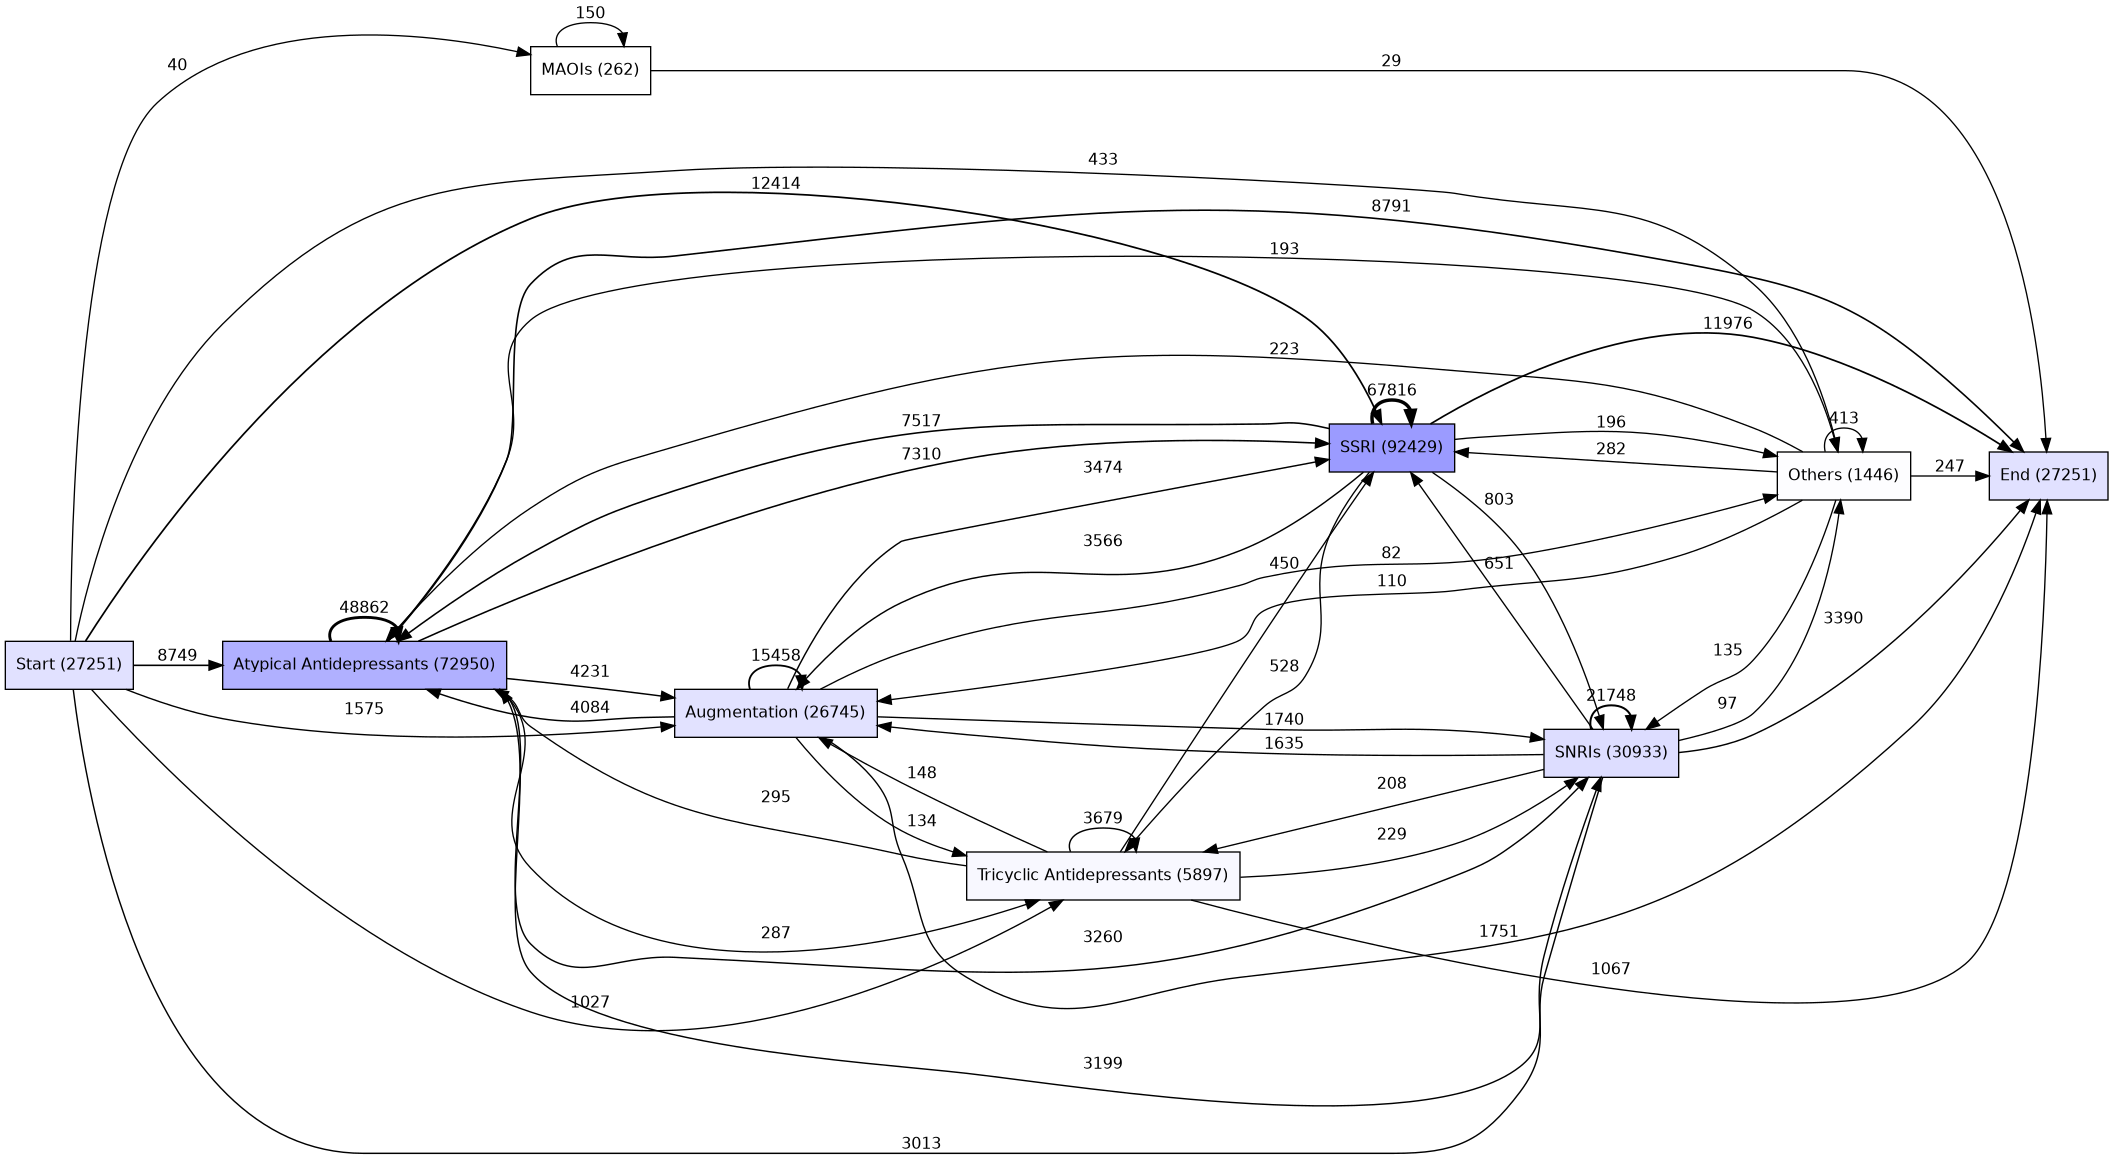

In [14]:
gviz_nontrd = dfg_visualizer.apply(
    filtered_dfg_nontrd, 
    log=nontrdlog_with_start_end, 
    variant=dfg_visualizer.Variants.FREQUENCY
)
dfg_visualizer.view(gviz_nontrd)

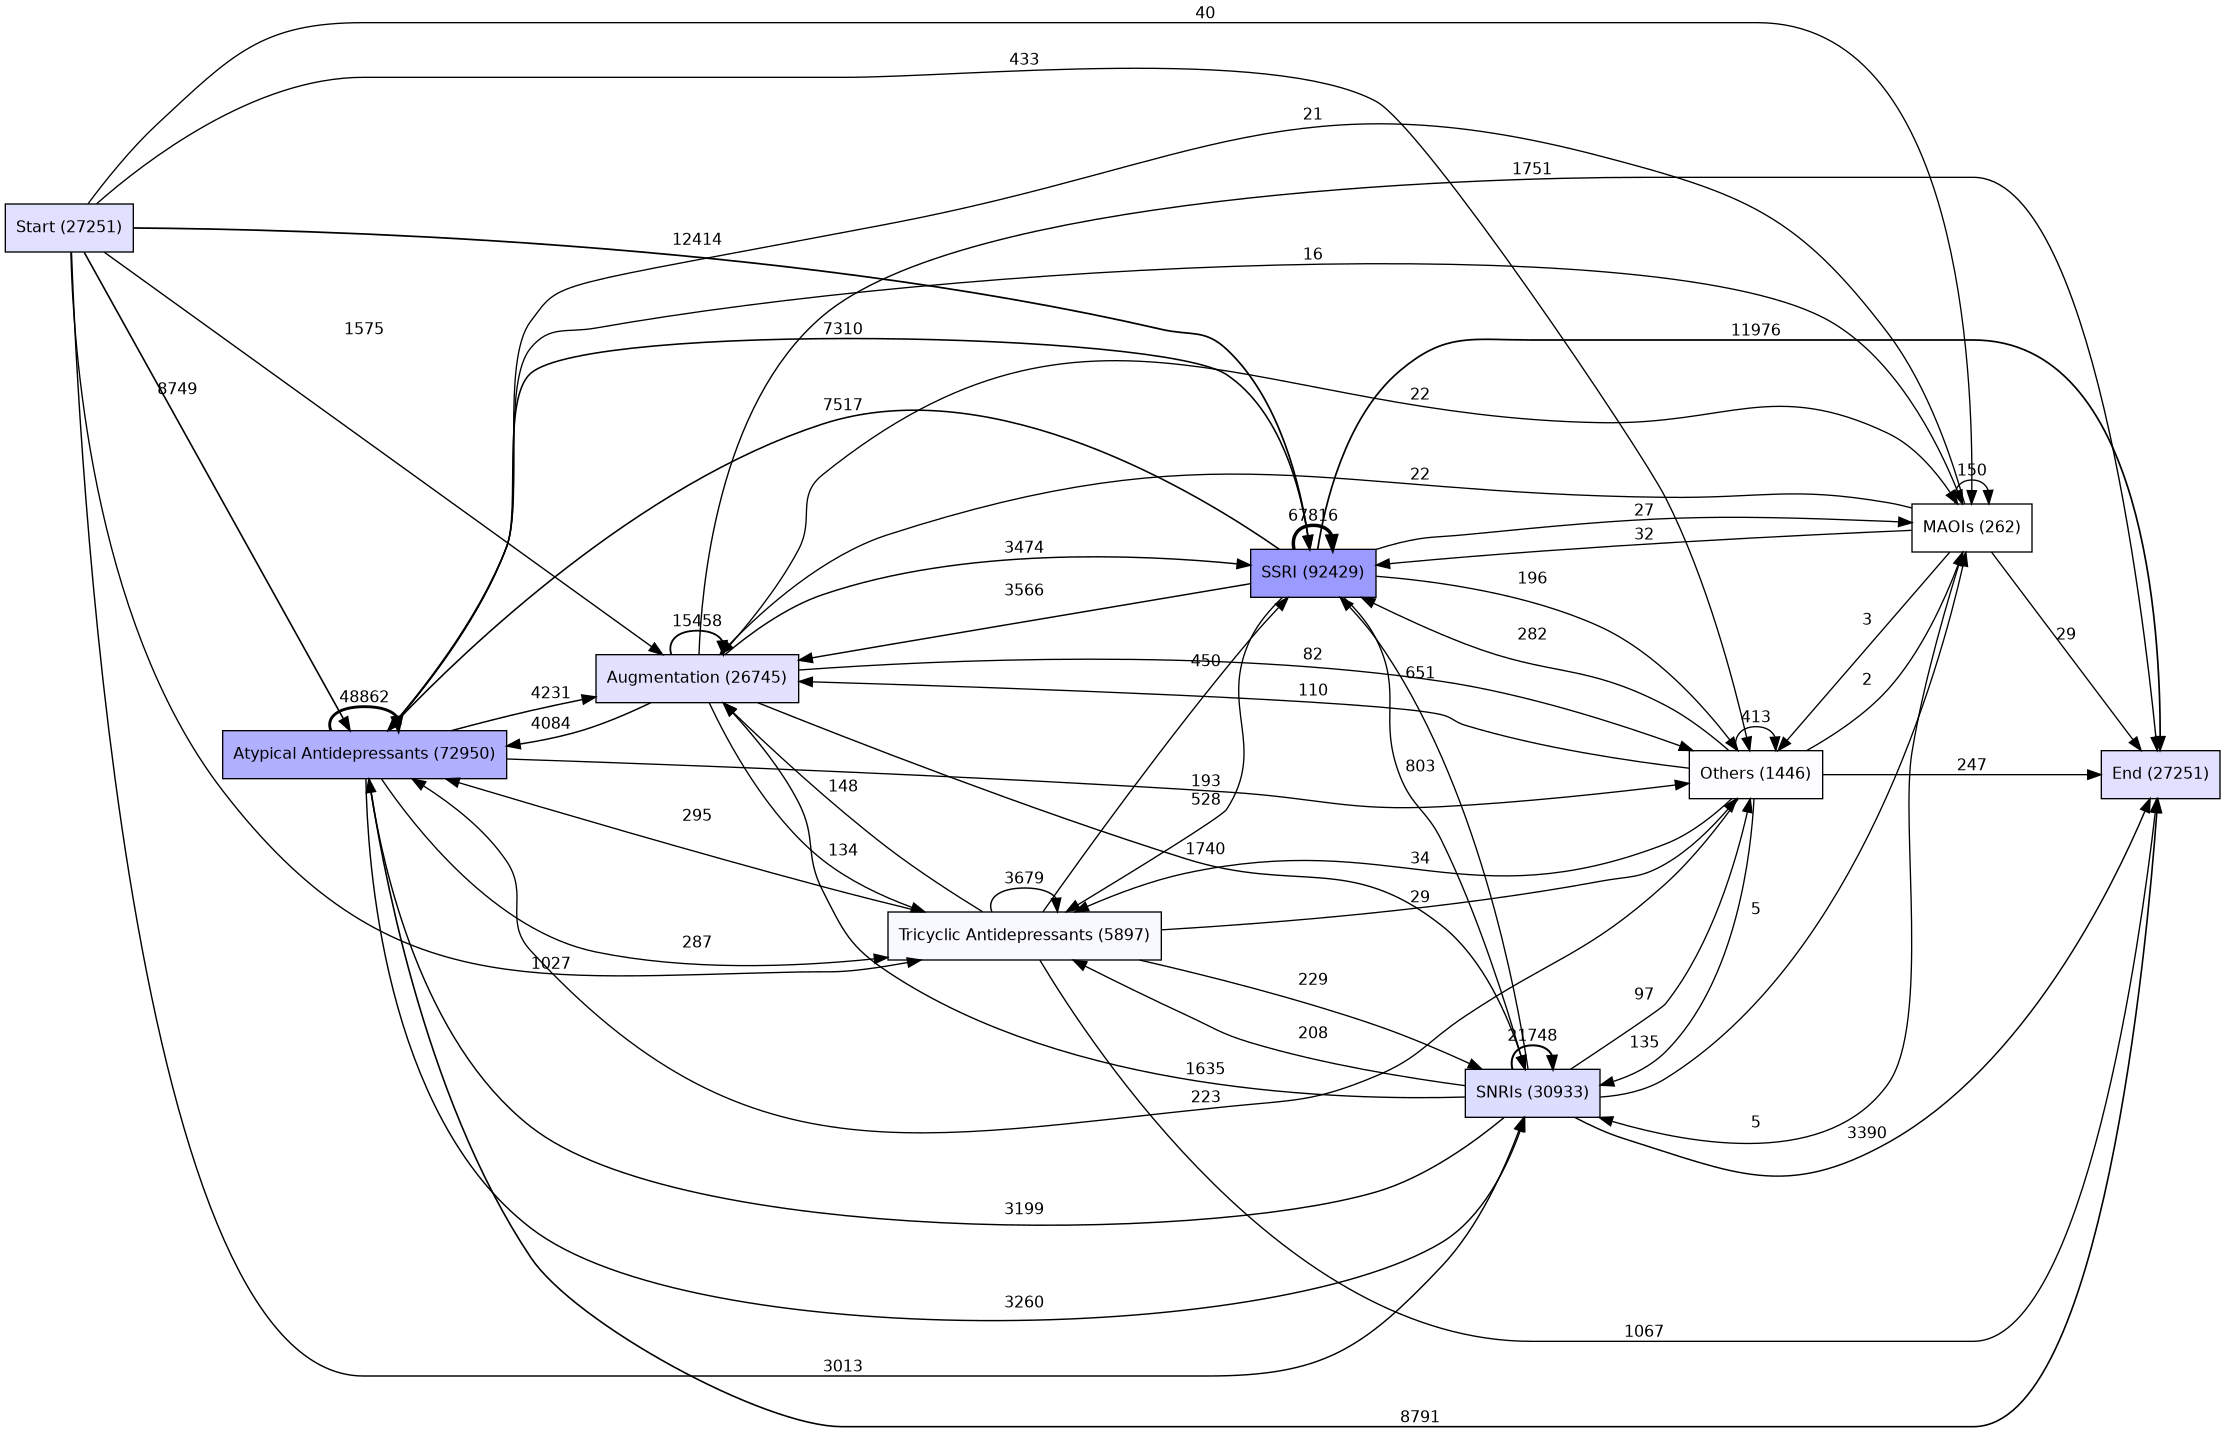

In [11]:
gviz_nontrd = dfg_visualizer.apply(
    dfg_nontrd, 
    log=nontrdlog_with_start_end, 
    variant=dfg_visualizer.Variants.FREQUENCY
)
dfg_visualizer.view(gviz_nontrd)

In [15]:
log_edges = set()
for trace in trdlog_with_start_end:
    for i in range(len(trace)-1):
        a = trace[i]['concept:name']
        b = trace[i+1]['concept:name']
        log_edges.add((a, b))

# 2. All edges in the DFG
dfg_edges = set(dfg_trd.keys())

# 3. Coverage calculation
missing_edges = log_edges - dfg_edges
edge_coverage = len(dfg_edges & log_edges) / len(log_edges)

print(f"Edge coverage: {edge_coverage:.3f} ({len(dfg_edges & log_edges)} / {len(log_edges)})")
if missing_edges:
    print(f"Directly-follows pairs in log but not in DFG: {missing_edges}")
else:
    print("All log edges are covered in DFG.")

Edge coverage: 1.000 (61 / 61)
All log edges are covered in DFG.


In [16]:
log_edges = set()
for trace in trdlog_with_start_end:
    for i in range(len(trace)-1):
        a = trace[i]['concept:name']
        b = trace[i+1]['concept:name']
        log_edges.add((a, b))

# 2. All edges in the DFG
filtered_dfg_edges = set(filtered_dfg_trd.keys())

# 3. Coverage calculation
missing_edges = log_edges - filtered_dfg_edges
edge_coverage = len(filtered_dfg_edges & log_edges) / len(log_edges)

print(f"Edge coverage: {edge_coverage:.3f} ({len(filtered_dfg_edges & log_edges)} / {len(log_edges)})")
if missing_edges:
    print(f"Directly-follows pairs in log but not in DFG: {missing_edges}")
else:
    print("All log edges are covered in DFG.")

Edge coverage: 0.803 (49 / 61)
Directly-follows pairs in log but not in DFG: {('Tricyclic Antidepressants', 'MAOIs'), ('MAOIs', 'Augmentation'), ('Others', 'Tricyclic Antidepressants'), ('SSRI', 'MAOIs'), ('MAOIs', 'Tricyclic Antidepressants'), ('Augmentation', 'Others'), ('Others', 'Augmentation'), ('SNRIs', 'MAOIs'), ('Tricyclic Antidepressants', 'Others'), ('MAOIs', 'SSRI'), ('MAOIs', 'SNRIs'), ('Augmentation', 'MAOIs')}


In [17]:
log_edges = set()
for trace in nontrdlog_with_start_end:
    for i in range(len(trace)-1):
        a = trace[i]['concept:name']
        b = trace[i+1]['concept:name']
        log_edges.add((a, b))

# 2. All edges in the DFG
dfg_edges = set(dfg_nontrd.keys())

# 3. Coverage calculation
missing_edges = log_edges - dfg_edges
edge_coverage = len(dfg_edges & log_edges) / len(log_edges)

print(f"Edge coverage: {edge_coverage:.3f} ({len(dfg_edges & log_edges)} / {len(log_edges)})")
if missing_edges:
    print(f"Directly-follows pairs in log but not in DFG: {missing_edges}")
else:
    print("All log edges are covered in DFG.")

Edge coverage: 1.000 (61 / 61)
All log edges are covered in DFG.


In [18]:
log_edges = set()
for trace in nontrdlog_with_start_end:
    for i in range(len(trace)-1):
        a = trace[i]['concept:name']
        b = trace[i+1]['concept:name']
        log_edges.add((a, b))

# 2. All edges in the DFG
filtered_dfg_edges = set(filtered_dfg_nontrd.keys())

# 3. Coverage calculation
missing_edges = log_edges - filtered_dfg_edges
edge_coverage = len(filtered_dfg_edges & log_edges) / len(log_edges)

print(f"Edge coverage: {edge_coverage:.3f} ({len(filtered_dfg_edges & log_edges)} / {len(log_edges)})")
if missing_edges:
    print(f"Directly-follows pairs in log but not in DFG: {missing_edges}")
else:
    print("All log edges are covered in DFG.")

Edge coverage: 0.803 (49 / 61)
Directly-follows pairs in log but not in DFG: {('MAOIs', 'Others'), ('MAOIs', 'Atypical Antidepressants'), ('MAOIs', 'Augmentation'), ('Atypical Antidepressants', 'MAOIs'), ('Others', 'Tricyclic Antidepressants'), ('SSRI', 'MAOIs'), ('SNRIs', 'MAOIs'), ('Tricyclic Antidepressants', 'Others'), ('MAOIs', 'SSRI'), ('MAOIs', 'SNRIs'), ('Others', 'MAOIs'), ('Augmentation', 'MAOIs')}


In [19]:

print("TRD edges:")
print(sorted(dfg_trd.keys()))

print("\nnonTRD edges:")
print(sorted(dfg_nontrd.keys()))


print("\nAre edge sets identical?", set(dfg_trd.keys()) == set(dfg_nontrd.keys()))
print("Number of edges in TRD:", len(dfg_trd))
print("Number of edges in nonTRD:", len(dfg_nontrd))

TRD edges:
[('Atypical Antidepressants', 'Atypical Antidepressants'), ('Atypical Antidepressants', 'Augmentation'), ('Atypical Antidepressants', 'End'), ('Atypical Antidepressants', 'MAOIs'), ('Atypical Antidepressants', 'Others'), ('Atypical Antidepressants', 'SNRIs'), ('Atypical Antidepressants', 'SSRI'), ('Atypical Antidepressants', 'Tricyclic Antidepressants'), ('Augmentation', 'Atypical Antidepressants'), ('Augmentation', 'Augmentation'), ('Augmentation', 'End'), ('Augmentation', 'MAOIs'), ('Augmentation', 'Others'), ('Augmentation', 'SNRIs'), ('Augmentation', 'SSRI'), ('Augmentation', 'Tricyclic Antidepressants'), ('MAOIs', 'Atypical Antidepressants'), ('MAOIs', 'Augmentation'), ('MAOIs', 'End'), ('MAOIs', 'MAOIs'), ('MAOIs', 'SNRIs'), ('MAOIs', 'SSRI'), ('MAOIs', 'Tricyclic Antidepressants'), ('Others', 'Atypical Antidepressants'), ('Others', 'Augmentation'), ('Others', 'End'), ('Others', 'Others'), ('Others', 'SNRIs'), ('Others', 'SSRI'), ('Others', 'Tricyclic Antidepressants')

Graph Density

In [20]:
activities = set()
for (src, tgt) in dfg_trd.keys():
    activities.add(src)
    activities.add(tgt)
n_activities = len(activities)

# 2. Count unique edges
n_edges = len(dfg_trd)

# 3. Calculate maximal possible edges (excluding self-loops)
max_possible_edges = n_activities * (n_activities - 1)

# 4. Compute edge coverage
edge_coverage = n_edges / max_possible_edges if max_possible_edges > 0 else float('nan')

print(f"Number of activities: {n_activities}")
print(f"Number of edges: {n_edges}")
print(f"Max possible edges: {max_possible_edges}")
print(f"Edge coverage: {edge_coverage:.4f}")


Number of activities: 9
Number of edges: 61
Max possible edges: 72
Edge coverage: 0.8472


In [21]:
activities = set()
for (src, tgt) in dfg_nontrd.keys():
    activities.add(src)
    activities.add(tgt)
n_activities = len(activities)

# 2. Count unique edges
n_edges = len(dfg_nontrd)

# 3. Calculate maximal possible edges (excluding self-loops)
max_possible_edges = n_activities * (n_activities - 1)

# 4. Compute edge coverage
edge_coverage = n_edges / max_possible_edges if max_possible_edges > 0 else float('nan')

print(f"Number of activities: {n_activities}")
print(f"Number of edges: {n_edges}")
print(f"Max possible edges: {max_possible_edges}")
print(f"Edge coverage: {edge_coverage:.4f}")


Number of activities: 9
Number of edges: 61
Max possible edges: 72
Edge coverage: 0.8472


In [22]:
print("TRD edges:")
print(sorted(filtered_dfg_trd.keys()))

print("\nnonTRD edges:")
print(sorted(filtered_dfg_nontrd.keys()))


print("\nAre edge sets identical?", set(filtered_dfg_trd.keys()) == set(filtered_dfg_nontrd.keys()))
print("Number of edges in TRD:", len(filtered_dfg_trd))
print("Number of edges in nonTRD:", len(filtered_dfg_nontrd))

TRD edges:
[('Atypical Antidepressants', 'Atypical Antidepressants'), ('Atypical Antidepressants', 'Augmentation'), ('Atypical Antidepressants', 'End'), ('Atypical Antidepressants', 'MAOIs'), ('Atypical Antidepressants', 'Others'), ('Atypical Antidepressants', 'SNRIs'), ('Atypical Antidepressants', 'SSRI'), ('Atypical Antidepressants', 'Tricyclic Antidepressants'), ('Augmentation', 'Atypical Antidepressants'), ('Augmentation', 'Augmentation'), ('Augmentation', 'End'), ('Augmentation', 'SNRIs'), ('Augmentation', 'SSRI'), ('Augmentation', 'Tricyclic Antidepressants'), ('MAOIs', 'Atypical Antidepressants'), ('MAOIs', 'End'), ('MAOIs', 'MAOIs'), ('Others', 'Atypical Antidepressants'), ('Others', 'End'), ('Others', 'Others'), ('Others', 'SNRIs'), ('Others', 'SSRI'), ('SNRIs', 'Atypical Antidepressants'), ('SNRIs', 'Augmentation'), ('SNRIs', 'End'), ('SNRIs', 'Others'), ('SNRIs', 'SNRIs'), ('SNRIs', 'SSRI'), ('SNRIs', 'Tricyclic Antidepressants'), ('SSRI', 'Atypical Antidepressants'), ('SSRI

In [23]:
print("Edges only in TRD:")
print(set(dfg_trd.keys()) - set(dfg_nontrd.keys()))

print("\nEdges only in nonTRD:")
print(set(dfg_nontrd.keys()) - set(dfg_trd.keys()))

Edges only in TRD:
{('Tricyclic Antidepressants', 'MAOIs'), ('MAOIs', 'Tricyclic Antidepressants')}

Edges only in nonTRD:
{('MAOIs', 'Others'), ('Others', 'MAOIs')}


In [24]:
print("Edges only in filtered_TRD:")
print(set(filtered_dfg_trd.keys()) - set(filtered_dfg_nontrd.keys()))

print("\nEdges only in filtered_nonTRD:")
print(set(filtered_dfg_nontrd.keys()) - set(filtered_dfg_trd.keys()))

Edges only in filtered_TRD:
{('Atypical Antidepressants', 'MAOIs'), ('MAOIs', 'Atypical Antidepressants')}

Edges only in filtered_nonTRD:
{('Augmentation', 'Others'), ('Others', 'Augmentation')}


In [25]:
# Unique edges in each group
trd_unique = set(dfg_trd.keys()) - set(dfg_nontrd.keys())
nontrd_unique = set(dfg_nontrd.keys()) - set(dfg_trd.keys())

print("TRD unique edge frequencies:")
for edge in trd_unique:
    print(f"{edge}: {dfg_trd[edge]}")

print("\nnonTRD unique edge frequencies:")
for edge in nontrd_unique:
    print(f"{edge}: {dfg_nontrd[edge]}")


TRD unique edge frequencies:
('Tricyclic Antidepressants', 'MAOIs'): 4
('MAOIs', 'Tricyclic Antidepressants'): 3

nonTRD unique edge frequencies:
('MAOIs', 'Others'): 3
('Others', 'MAOIs'): 2


In [26]:
print("Number of TRD traces:", len(trd_event_log))
print("Number of nonTRD traces:", len(nontrd_event_log))

Number of TRD traces: 4630
Number of nonTRD traces: 27251


In [27]:
variants_count = case_statistics.get_variant_statistics(trd_event_log)
print("Number of TRD variants:", len(variants_count))

variants_count = case_statistics.get_variant_statistics(nontrd_event_log)
print("Number of nonTRD variants:", len(variants_count))

num_events_trd = sum(len(trace) for trace in trd_event_log)
num_events_nontrd = sum(len(trace) for trace in nontrd_event_log)

print("Number of events in TRD log:", num_events_trd)
print("Number of events in non-TRD log:", num_events_nontrd)

trd_total_cases = len(trd_event_log)
nontrd_total_cases = len(nontrd_event_log)


print("Number of cases in TRD log:", trd_total_cases)
print("Number of cases in non-TRD log:", nontrd_total_cases)



trd_event_case_ratio = num_events_trd/trd_total_cases
nontrd_event_case_ratio = num_events_nontrd/nontrd_total_cases


print("Average number of events per case in TRD log:", trd_event_case_ratio)
print("Average number of events per cases in non-TRD log:", nontrd_event_case_ratio)

Number of TRD variants: 4332
Number of nonTRD variants: 4698
Number of events in TRD log: 184979
Number of events in non-TRD log: 230662
Number of cases in TRD log: 4630
Number of cases in non-TRD log: 27251
Average number of events per case in TRD log: 39.95226781857451
Average number of events per cases in non-TRD log: 8.464349932112583


In [28]:
variants_count = case_statistics.get_variant_statistics(trd_event_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
print("Top 10 variants:")
for i, var in enumerate(variants_count[:10]):
    print(f"{i+1}. Variant occurs in {var['count']} cases")

Top 10 variants:
1. Variant occurs in 16 cases
2. Variant occurs in 11 cases
3. Variant occurs in 10 cases
4. Variant occurs in 10 cases
5. Variant occurs in 10 cases
6. Variant occurs in 8 cases
7. Variant occurs in 7 cases
8. Variant occurs in 7 cases
9. Variant occurs in 7 cases
10. Variant occurs in 7 cases


In [29]:
variants_count = case_statistics.get_variant_statistics(nontrd_event_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
print("Top 10 variants:")
for i, var in enumerate(variants_count[:10]):
    print(f"{i+1}. Variant occurs in {var['count']} cases")

Top 10 variants:
1. Variant occurs in 2943 cases
2. Variant occurs in 1960 cases
3. Variant occurs in 1618 cases
4. Variant occurs in 1112 cases
5. Variant occurs in 1023 cases
6. Variant occurs in 808 cases
7. Variant occurs in 738 cases
8. Variant occurs in 670 cases
9. Variant occurs in 552 cases
10. Variant occurs in 487 cases


In [30]:
total_events = sum([len(trace) for trace in trd_event_log])
print("Total events in TRD log:", total_events)

Total events in TRD log: 184979


In [31]:
total_events = sum([len(trace) for trace in nontrd_event_log])
print("Total events in nonTRD log:", total_events)

Total events in nonTRD log: 230662


In [32]:

trd_variants = case_statistics.get_variant_statistics(trd_event_log)
trd_variants_count = sorted(trd_variants, key=lambda x: x['count'], reverse=True)


In [33]:
trd_variants_count[0]

{'variant': ('Atypical Antidepressants',
  'Atypical Antidepressants',
  'Atypical Antidepressants',
  'Atypical Antidepressants',
  'Atypical Antidepressants',
  'Atypical Antidepressants'),
 'count': 16}

In [34]:
nontrd_variants = case_statistics.get_variant_statistics(nontrd_event_log)
nontrd_variants_count = sorted(nontrd_variants, key=lambda x: x['count'], reverse=True)

In [35]:
nontrd_variants_count[0]

{'variant': ('SSRI',), 'count': 2943}

In [36]:
from collections import defaultdict


trd_single_category_freq = defaultdict(int)
for v in trd_variants:
    variant = v['variant']
    if len(set(variant)) == 1:
        cat = variant[0]  
        trd_single_category_freq[cat] += v['count']


for cat, freq in trd_single_category_freq.items():
    print(f"{cat}: {freq}")


Atypical Antidepressants: 183
SSRI: 39
Tricyclic Antidepressants: 3
SNRIs: 1
MAOIs: 1
Augmentation: 1


In [37]:
nontrd_single_category_freq = defaultdict(int)
for v in nontrd_variants:
    variant = v['variant']
    if len(set(variant)) == 1:
        cat = variant[0] 
        nontrd_single_category_freq[cat] += v['count']


for cat, freq in nontrd_single_category_freq.items():
    print(f"{cat}: {freq}")

SSRI: 9870
Atypical Antidepressants: 6471
SNRIs: 2208
Tricyclic Antidepressants: 712
Augmentation: 848
Others: 23
MAOIs: 9


In [38]:
total_single_category_cases = sum(trd_single_category_freq.values())
print("Total cases with single-category variants:", total_single_category_cases)


Total cases with single-category variants: 228


In [39]:
total_single_category_cases = sum(nontrd_single_category_freq.values())
print("Total cases with single-category variants:", total_single_category_cases)


Total cases with single-category variants: 20141


In [40]:
from pm4py.statistics.start_activities.log import get as start_act_get

trd_start_act_dict = start_act_get.get_start_activities(trd_event_log)
print(trd_start_act_dict)


{'Augmentation': 333, 'Atypical Antidepressants': 1558, 'SNRIs': 576, 'SSRI': 1927, 'Tricyclic Antidepressants': 178, 'Others': 36, 'MAOIs': 22}


In [41]:
from pm4py.statistics.start_activities.log import get as start_act_get

nontrd_start_act_dict = start_act_get.get_start_activities(nontrd_event_log)
print(nontrd_start_act_dict)


{'SSRI': 12414, 'Atypical Antidepressants': 8749, 'Augmentation': 1575, 'SNRIs': 3013, 'Tricyclic Antidepressants': 1027, 'Others': 433, 'MAOIs': 40}


In [42]:
trd_start_act_dict = {str(k): v for k, v in trd_start_act_dict.items()}
nontrd_start_act_dict = {str(k): v for k, v in nontrd_start_act_dict.items()}

# All unique activities
all_activities = sorted(set(trd_start_act_dict) | set(nontrd_start_act_dict))

# Prepare data in order
trd_counts = [trd_start_act_dict.get(act, 0) for act in all_activities]
nontrd_counts = [nontrd_start_act_dict.get(act, 0) for act in all_activities]


trd_total_cases = len(trd_event_log)
nontrd_total_cases = len(nontrd_event_log)


trd_ratios = [count / trd_total_cases for count in trd_counts]
nontrd_ratios = [count / nontrd_total_cases for count in nontrd_counts]



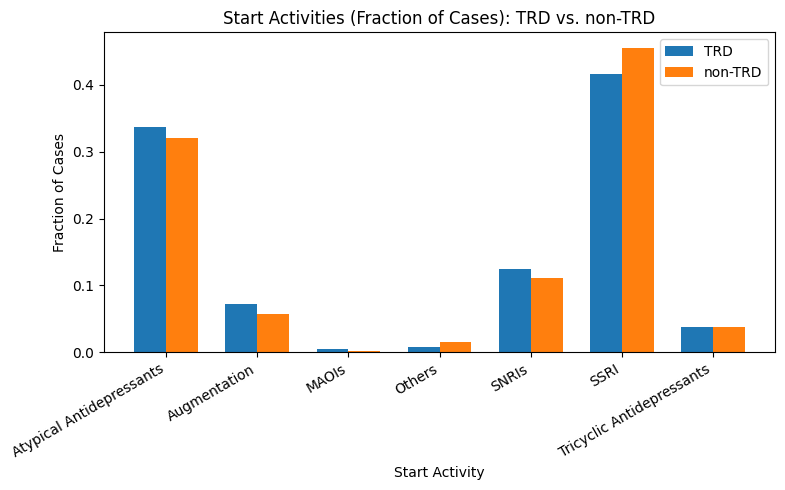

In [43]:
bar_width = 0.35
x = np.arange(len(all_activities))

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - bar_width/2, trd_ratios, width=bar_width, label='TRD')
bars2 = ax.bar(x + bar_width/2, nontrd_ratios, width=bar_width, label='non-TRD')

ax.set_xlabel('Start Activity')
ax.set_ylabel('Fraction of Cases')
ax.set_title('Start Activities (Fraction of Cases): TRD vs. non-TRD')
ax.set_xticks(x)
ax.set_xticklabels(all_activities, rotation=30, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [44]:

avg_case_arrival = get_case_arrival_avg(trd_event_log)
print(f"TRD: Avg inter-arrival time (sec): {avg_case_arrival}")

TRD: Avg inter-arrival time (sec): 125260.40181464679


In [45]:

avg_case_arrival = get_case_arrival_avg(nontrd_event_log)
print(f"nonTRD: Avg inter-arrival time (sec): {avg_case_arrival}")

nonTRD: Avg inter-arrival time (sec): 21769.629357798167


In [46]:

avg_case_dispersion = get_case_dispersion_avg(trd_event_log)
print(f"TRD: Avg inter-end time (sec): {avg_case_dispersion}")

TRD: Avg inter-end time (sec): 113221.51652624756


In [47]:

avg_case_dispersion = get_case_dispersion_avg(nontrd_event_log)
print(f"nonTRD: Avg inter-end time (sec): {avg_case_dispersion}")

nonTRD: Avg inter-end time (sec): 21344.763302752293


In [48]:
from pm4py.statistics.traces.generic.log.case_statistics import (
    get_all_case_durations,
    get_median_case_duration,
    get_first_quartile_case_duration,
    get_cases_description,
    get_variant_statistics
)

trd_durations = get_all_case_durations(trd_event_log)
trd_median = get_median_case_duration(trd_event_log)
trd_first_q = get_first_quartile_case_duration(trd_event_log)
trd_cases_desc = get_cases_description(trd_event_log)  


In [49]:
print('trd_median duration', trd_median)
print('trd_min duration', np.min(trd_durations))
print('trd_max duration', np.max(trd_durations))

trd_median duration 127267200.0
trd_min duration 950400.0
trd_max duration 560044800.0


In [53]:
cases_desc = get_cases_description(trd_event_log)


zero_duration_cases = [
    case_id
    for case_id, info in cases_desc.items()
    if info["caseDuration"] == 0
]

print(f"Cases with zero duration ({len(zero_duration_cases)}):")
print(zero_duration_cases)

Cases with zero duration (0):
[]


In [54]:
nontrd_durations = get_all_case_durations(nontrd_event_log)
nontrd_median = get_median_case_duration(nontrd_event_log)
nontrd_first_q = get_first_quartile_case_duration(nontrd_event_log)
nontrd_cases_desc = get_cases_description(nontrd_event_log)    


In [55]:
print('nontrd_median duration', nontrd_median)
print('nontrd_min duration', np.min(nontrd_durations))
print('nontrd_max duration', np.max(nontrd_durations))

nontrd_median duration 9676800.0
nontrd_min duration 0.0
nontrd_max duration 570153600.0


In [56]:
cases_desc = get_cases_description(nontrd_event_log)


zero_duration_cases = [
    case_id
    for case_id, info in cases_desc.items()
    if info["caseDuration"] == 0
]

print(f"Cases with zero duration ({len(zero_duration_cases)}):")
print(zero_duration_cases)

Cases with zero duration (6670):
['1001393', '1001411', '1001648', '1004313', '1004420', '1006593', '1007574', '1007685', '1010054', '1010921', '1011440', '1013290', '1013785', '1013976', '1014002', '1014463', '1015932', '1017261', '1017446', '1017921', '1018492', '1018645', '1018865', '1019325', '1019493', '1019543', '1019745', '1020216', '1021613', '1022509', '1022537', '1024596', '1025327', '1025548', '1025632', '1025701', '1026423', '1027325', '1027979', '1028601', '1028736', '1029523', '1029819', '1030747', '1030993', '1031358', '1031378', '1031474', '1031870', '1033974', '1034654', '1035473', '1035642', '1035650', '1036716', '1036952', '1037772', '1037798', '1038333', '1038904', '1040584', '1040715', '1041930', '1041931', '1042111', '1042155', '1042710', '1043409', '1043651', '1044658', '1044967', '1045264', '1045463', '1046059', '1046296', '1046696', '1047949', '1048278', '1048732', '1048985', '1051396', '1051670', '1051984', '1052265', '1053460', '1053837', '1054000', '1054357'

In [57]:
def print_duration_summary(durations, label="Group"):
    durations = np.array(durations)
    print(f"=== {label} ===")
    print("Number of cases:", len(durations))
    print("Min duration:", np.min(durations))
    print("Max duration:", np.max(durations))
    print("Mean duration:", np.mean(durations))
    print("Median duration:", np.median(durations))
    print("25% duration:", np.percentile(durations, 25))
    print("75% duration:", np.percentile(durations, 75))
    print("Std deviation:", np.std(durations))
    print()

print_duration_summary(trd_durations, "TRD")
print_duration_summary(nontrd_durations, "Non-TRD")


=== TRD ===
Number of cases: 4630
Min duration: 950400.0
Max duration: 560044800.0
Mean duration: 154629856.06911448
Median duration: 127267200.0
25% duration: 67132800.0
75% duration: 211680000.0
Std deviation: 112908011.99592143

=== Non-TRD ===
Number of cases: 27251
Min duration: 0.0
Max duration: 570153600.0
Mean duration: 41479155.876848556
Median duration: 9676800.0
25% duration: 86400.0
75% duration: 54345600.0
Std deviation: 68290371.86591391



In [59]:
case_lengths = [len(trace) for trace in trd_event_log]

print("Number of cases:", len(case_lengths))
print("Min length:", np.min(case_lengths))
print("Max length:", np.max(case_lengths))
print("Mean length:", np.mean(case_lengths))
print("Median length:", np.median(case_lengths))
print("25%:", np.percentile(case_lengths, 25))
print("75%:", np.percentile(case_lengths, 75))
print("Std:", np.std(case_lengths))

Number of cases: 4630
Min length: 3
Max length: 1064
Mean length: 39.95226781857451
Median length: 23.0
25%: 12.0
75%: 46.0
Std: 55.926093723948306


In [60]:
case_lengths = [len(trace) for trace in nontrd_event_log]

print("Number of cases:", len(case_lengths))
print("Min length:", np.min(case_lengths))
print("Max length:", np.max(case_lengths))
print("Mean length:", np.mean(case_lengths))
print("Median length:", np.median(case_lengths))
print("25%:", np.percentile(case_lengths, 25))
print("75%:", np.percentile(case_lengths, 75))
print("Std:", np.std(case_lengths))

Number of cases: 27251
Min length: 1
Max length: 1174
Mean length: 8.464349932112583
Median length: 4.0
25%: 2.0
75%: 9.0
Std: 17.34479407826799
